### remember to change model saving path!!!

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import os
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm
import random
import torch.nn as nn
from dataset import Thyroid_Dataset
from model import Eff_Unet
from HarDMSEG import HarDMSEG
from loss_metric import DiceLoss, IOU_score, StructureLoss, TverskyLoss
from LightMed.model.LightMed import LightMed
from PMFSNet.lib.models.PMFSNet import PMFSNet
from PMFSNet.lib.models.PMFSNet_FFT import PMFSNet_FFT
from hybrid_model_v3 import HybridSegModel

/home/twszbak764/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/twszbak764/.local/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/twszbak764/.local/lib/python3.12/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [3]:
import wandb
wandb.login()

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: s960068sss (s960068sss-ucl) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import os
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms.functional as tx
import random
import cv2
from PIL import ImageEnhance
from skimage.exposure import match_histograms
import torchvision.transforms as T
import torchvision.transforms.functional as F
class Ge_Benq_Dataset(Dataset):
    def __init__(self, csv_file, transform, image_size, training = True):
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.image_size = image_size
        self.training = training
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_name = self.df["image_name"][idx]
        mask_name = self.df["mask_name"][idx]
        dataset = self.df["dataset"][idx]
        mask_type = self.df["mask_type"][idx]
        inference = self.df["inference"][idx]
        
        if dataset == "ge":
            from_dataset = 1
        elif dataset == "benq":
            from_dataset = 2

        if mask_type == "nodule":
            mask_type = 1
        elif mask_type == "gland":
            mask_type = 2

            
        if dataset == "benq":
            from_folder = "../gland_data"
        elif dataset == "ge":
            if mask_type == 1:
                if self.training:
                    from_folder = "../ge_data/nodule/train"
                else:
                    from_folder = "../ge_data/nodule/test"
            else:
                from_folder = "../ge_data/gland"
                
        if inference == False:
            image_path = f"{from_folder}/images/{image_name}"
            mask_path = f"{from_folder}/masks/{mask_name}"
        else:
            image_path = f"../ge_data/from_videos/images/{image_name}"
            if mask_type == 1:
                mask_path = f"../ge_data/from_videos/inference_mask/nodule/{mask_name}"
            else:
                mask_path = f"../ge_data/from_videos/inference_mask/gland/{mask_name}"

        image = Image.open(image_path).convert("L")
        mask = Image.open(mask_path).convert("L")
        
        image_tensor, mask_tensor = self.transform(image, mask, self.image_size)
        mask_tensor = (mask_tensor > 0.5).float()
        if torch.sum(mask_tensor) == 0:
            # print("nothing")
            return [None]
        return image_tensor, mask_tensor, from_dataset, mask_type, inference

In [6]:
image_size = 128
batch_size = 256
def train_augmentation(image, mask, image_size):
    resize = T.Resize((image_size, image_size))
    image = resize(image)
    mask = resize(mask)

    p = 0.7
    
    # if(random.random() < p):
    #     jitter = T.ColorJitter(brightness = 0.5, contrast = 0.25)
    #     image = jitter(image)
    # if(random.random() < p):
    #     transform = T.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))
    #     image = transform(image)  # image must be a PIL image
    if(random.random() < p):
        # angle = random.uniform(-10, 10)  # 旋轉角度從 ±10 度
        angle = 0.0
        max_dx = 0.05  # 水平平移比例
        max_dy = 0.3  # 垂直平移比例
        translate_x = random.uniform(-max_dx, max_dx) * image.size[0]
        translate_y = random.uniform(-max_dy, max_dy) * image.size[1]
        translate = (int(translate_x), int(translate_y))
        scale = random.uniform(0.9, 1.6)  # 尺度縮放 ±5%
        # scale = 1.0
        # shear = [random.uniform(-5, 5), random.uniform(-5, 5)]  # 小幅剪切
        shear=[0.0, 0.0]
        image = F.affine(image, angle=angle, translate=translate, scale=scale, shear=shear)
        mask = F.affine(mask, angle=angle, translate=translate, scale=scale, shear=shear)

        
    image_tensor = tx.to_tensor(image)
    mask_tensor = tx.to_tensor(mask)

    # If standardization
    mean = image_tensor.mean()
    std = image_tensor.std()
    std = std if std > 0 else 1.0  # avoid division by zero
    image_tensor = (image_tensor - mean) / std
    return image_tensor, mask_tensor
def test_augmentation(image, mask, image_size):
    resize = T.Resize((image_size, image_size))
    image = resize(image)
    mask = resize(mask)

    image_tensor = tx.to_tensor(image)
    mask_tensor = tx.to_tensor(mask)

    # If standardization
    mean = image_tensor.mean()
    std = image_tensor.std()
    std = std if std > 0 else 1.0  # avoid division by zero
    image_tensor = (image_tensor - mean) / std
    return image_tensor, mask_tensor
def custom_collate_fn(batch):
    # print(batch)
    filtered_batch = [item for item in batch if item[0] is not None]
    if len(filtered_batch) == 0:
        return [None, None]
    return torch.utils.data.dataloader.default_collate(filtered_batch)
train_dataset = Ge_Benq_Dataset("../ge_benq_data/ge_benq_train_v3.csv", transform = train_augmentation, image_size = image_size)
train_dataloader = DataLoader(train_dataset, batch_size = 256, shuffle = True, collate_fn=custom_collate_fn)

test_dataset = Ge_Benq_Dataset("../ge_benq_data/ge_benq_test_v3.csv", transform = test_augmentation, image_size = image_size, training = False)
test_dataloader = DataLoader(test_dataset, batch_size = 128, shuffle = False, collate_fn=custom_collate_fn)

image, mask, from_dataset, mask_type, inference = next(iter(train_dataloader))

In [7]:
print(len(train_dataset), len(test_dataset))

1077 229


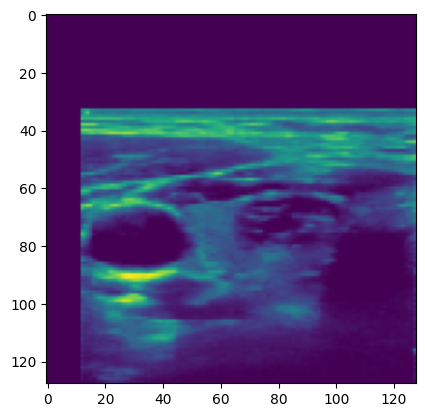

In [8]:
plt.imshow(image[22][0])

In [9]:
def train(dataloader, model, optimizer, loss_fn, device):
    total_loss = 0
    total_IOU = 0
    total_DICE = 0

    total_ge_nodule_IOU = 0
    total_ge_gland_IOU = 0
    total_benq_gland_IOU = 0
    
    total_ge_nodule_DICE = 0
    total_ge_gland_DICE = 0
    total_benq_gland_DICE = 0
    
    model.train()
    model.to(device)
    
    count = 0
    for image, mask, from_dataset, mask_type, infernce in tqdm(dataloader):
        if image == None:
            continue
        image, mask = image.to(device), mask.to(device)
        
        outputs = model(image)
        
        nodule_output = outputs[:, 0:1, :, :]
        gland_output = outputs[:, 1:2, :, :]

        # get output
        ge_nodule_output = nodule_output[(from_dataset == 1) & (mask_type == 1)]
        ge_gland_output = gland_output[(from_dataset == 1) & (mask_type == 2)]
        benq_gland_output = gland_output[(from_dataset == 2) & (mask_type == 2)]

        # get len
        ge_nodule_len = ge_nodule_output.shape[0]
        ge_gland_len = ge_gland_output.shape[0]
        benq_gland_len = benq_gland_output.shape[0]

        if ge_nodule_len == 0 or ge_gland_len == 0 or benq_gland_len == 0:
            continue

        nodule_ratio = ge_nodule_len / (ge_nodule_len + ge_gland_len + benq_gland_len)
        gland_ratio = (ge_gland_len + benq_gland_len) / (ge_nodule_len + ge_gland_len + benq_gland_len)
        
        ge_gland_ratio = ge_gland_len / (ge_gland_len + benq_gland_len)
        benq_gland_ratio = benq_gland_len / (ge_gland_len + benq_gland_len)
        
        # get mask
        ge_nodule_mask = mask[(from_dataset == 1) & (mask_type == 1)]
        ge_gland_mask = mask[(from_dataset == 1) & (mask_type == 2)]
        benq_gland_mask = mask[(from_dataset == 2) & (mask_type == 2)]
        
        #get loss
        ge_nodule_loss = loss_fn(ge_nodule_output, ge_nodule_mask)
        ge_gland_loss = loss_fn(ge_gland_output, ge_gland_mask)
        benq_gland_loss = loss_fn(benq_gland_output, benq_gland_mask)

        nodule_loss = ge_nodule_loss
        gland_loss = (ge_gland_loss * ge_gland_ratio + benq_gland_loss * benq_gland_ratio)
        loss = (nodule_loss * nodule_ratio * 1.3 + gland_loss * gland_ratio * 0.7)
        
        # get IOU
        ge_nodule_IOU = IOU_score(ge_nodule_output, ge_nodule_mask)
        ge_gland_IOU = IOU_score(ge_gland_output, ge_gland_mask)
        benq_gland_IOU = IOU_score(benq_gland_output, benq_gland_mask)

        nodule_IOU = ge_nodule_IOU
        gland_IOU = (ge_gland_IOU * ge_gland_ratio + benq_gland_IOU * benq_gland_ratio)
        IOU = (nodule_IOU * nodule_ratio + gland_IOU * gland_ratio)

        # get DICE
        dice_loss = DiceLoss()
        
        ge_nodule_DICE = 1 - dice_loss(ge_nodule_output, ge_nodule_mask)
        ge_gland_DICE = 1 - dice_loss(ge_gland_output, ge_gland_mask)
        benq_gland_DICE = 1 - dice_loss(benq_gland_output, benq_gland_mask)

        nodule_DICE = ge_nodule_DICE
        gland_DICE = (ge_gland_DICE * ge_gland_ratio + benq_gland_DICE * benq_gland_ratio)
        DICE = (nodule_DICE * nodule_ratio + gland_DICE * gland_ratio)

        
        # Backward and optimize
        optimizer.zero_grad()   # clear previous gradients
        loss.backward()         # compute gradients
        optimizer.step()        # update weights

        total_loss += loss.item()
        total_IOU += IOU.item()
        total_DICE += DICE.item()

        total_ge_nodule_IOU += ge_nodule_IOU
        total_ge_gland_IOU += ge_gland_IOU
        total_benq_gland_IOU += benq_gland_IOU

        total_ge_nodule_DICE += ge_nodule_DICE
        total_ge_gland_DICE += ge_gland_DICE
        total_benq_gland_DICE += benq_gland_DICE
        count+=1

    return total_loss/count, total_IOU/count, total_DICE/count, total_ge_nodule_IOU/count, total_ge_gland_IOU/count, total_benq_gland_IOU/count, total_ge_nodule_DICE/count, total_ge_gland_DICE/count, total_benq_gland_DICE/count


# 
# Only calculate nodule loss, IOU, DICE, because there is no gland data in the testing set
def val(dataloader, model, loss_fn, device):
    total_loss = 0
    total_IOU = 0
    total_DICE = 0

    total_ge_nodule_IOU = 0
    total_ge_gland_IOU = 0
    total_benq_gland_IOU = 0
    
    total_ge_nodule_DICE = 0
    total_ge_gland_DICE = 0
    total_benq_gland_DICE = 0
    
    model.train()
    model.to(device)
    count = 0
    for image, mask, from_dataset, mask_type, infernce in tqdm(dataloader):
        if image == None:
            continue
        image, mask = image.to(device), mask.to(device)
        
        outputs = model(image)
        
        nodule_output = outputs[:, 0:1, :, :]
        gland_output = outputs[:, 1:2, :, :]

        # get output
        ge_nodule_output = nodule_output[(from_dataset == 1) & (mask_type == 1)]
        ge_gland_output = gland_output[(from_dataset == 1) & (mask_type == 2)]
        benq_gland_output = gland_output[(from_dataset == 2) & (mask_type == 2)]

        # get len
        ge_nodule_len = ge_nodule_output.shape[0]
        ge_gland_len = ge_gland_output.shape[0]
        benq_gland_len = benq_gland_output.shape[0]

        if ge_nodule_len == 0 or ge_gland_len == 0 or benq_gland_len == 0:
            continue
        nodule_ratio = ge_nodule_len / (ge_nodule_len + ge_gland_len + benq_gland_len)
        gland_ratio = (ge_gland_len + benq_gland_len) / (ge_nodule_len + ge_gland_len + benq_gland_len)
        
        ge_gland_ratio = ge_gland_len / (ge_gland_len + benq_gland_len)
        benq_gland_ratio = benq_gland_len / (ge_gland_len + benq_gland_len)
        
        # get mask
        ge_nodule_mask = mask[(from_dataset == 1) & (mask_type == 1)]
        ge_gland_mask = mask[(from_dataset == 1) & (mask_type == 2)]
        benq_gland_mask = mask[(from_dataset == 2) & (mask_type == 2)]
        
        #get loss
        ge_nodule_loss = loss_fn(ge_nodule_output, ge_nodule_mask)
        ge_gland_loss = loss_fn(ge_gland_output, ge_gland_mask)
        benq_gland_loss = loss_fn(benq_gland_output, benq_gland_mask)

        nodule_loss = ge_nodule_loss
        gland_loss = (ge_gland_loss * ge_gland_ratio + benq_gland_loss * benq_gland_ratio)
        loss = (nodule_loss * nodule_ratio + gland_loss * gland_ratio)
        
        # get IOU
        ge_nodule_IOU = IOU_score(ge_nodule_output, ge_nodule_mask)
        ge_gland_IOU = IOU_score(ge_gland_output, ge_gland_mask)
        benq_gland_IOU = IOU_score(benq_gland_output, benq_gland_mask)

        nodule_IOU = ge_nodule_IOU
        gland_IOU = (ge_gland_IOU * ge_gland_ratio + benq_gland_IOU * benq_gland_ratio)
        IOU = (nodule_IOU * nodule_ratio + gland_IOU * gland_ratio)

        # get DICE
        dice_loss = DiceLoss()
        
        ge_nodule_DICE = 1 - dice_loss(ge_nodule_output, ge_nodule_mask)
        ge_gland_DICE = 1 - dice_loss(ge_gland_output, ge_gland_mask)
        benq_gland_DICE = 1 - dice_loss(benq_gland_output, benq_gland_mask)

        nodule_DICE = ge_nodule_DICE
        gland_DICE = (ge_gland_DICE * ge_gland_ratio + benq_gland_DICE * benq_gland_ratio)
        DICE = (nodule_DICE * nodule_ratio + gland_DICE * gland_ratio)

        total_loss += loss.item()
        total_IOU += IOU.item()
        total_DICE += DICE.item()

        total_ge_nodule_IOU += ge_nodule_IOU
        total_ge_gland_IOU += ge_gland_IOU
        total_benq_gland_IOU += benq_gland_IOU

        total_ge_nodule_DICE += ge_nodule_DICE
        total_ge_gland_DICE += ge_gland_DICE
        total_benq_gland_DICE += benq_gland_DICE
        count+=1

    return total_loss/count, total_IOU/count, total_DICE/count, total_ge_nodule_IOU/count, total_ge_gland_IOU/count, total_benq_gland_IOU/count, total_ge_nodule_DICE/count, total_ge_gland_DICE/count, total_benq_gland_DICE/count

    

In [25]:

# inference_name = "models/Phase 1/Hybrid_crop_DDTI_standardization_aug_affine(0.5)_for_gland"

model = HybridSegModel(in_channels = 1, out_channels = 2, output_size = image_size, layers_num = 3)
# checkpoint = torch.load(f"{inference_name}/best_checkpoint.pth")
# model.load_state_dict(checkpoint['model_state_dict'])


In [26]:
# freeze encoder
# for param in model.backbone.parameters():
#     param.requires_grad = False

In [27]:

epochs = 500
lr = 0.01
loss_fn = StructureLoss()
# loss_fn = TverskyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
# optimizer = optim.AdamW(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

In [28]:

project = "thyroid_ge_benq_finetune"
# name = "hybrid_model_ge(nodule_gland_inference)_v3_benq(crop_gland)_baseline(1)_freeze_encoder_aug_space_adjust_loss(1.3_0.7)"
name = "test"

wandb.init(
    project = project,  # Project name in W&B
    name = name,       # (optional) specific run name
    config={                     # (optional) hyperparameters
        "image_size": image_size,
        "learning_rate": lr,
        "epochs": epochs,
        "batch_size": batch_size,
        # "weight_decay":1e-4
    }
)

Learning Rate,███████▇▇▇▇▇▆▆▆▅▅▅▄▄▃▃▃▂▂▁
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
train_DICE,▁▃▄▅▅▅▅▅▆▅▆▆▆▇▇▇▇▆▇▇▇█▇▇██
train_IOU,▁▃▄▄▅▄▅▆▆▆▆▆▆▇▆▇▇▆▇█▇█▇▇██
train_benq_gland_DICE,▁▄▅▅▄▄▅▆▅▆▆▅▆▆▆▇▇▇▇████▇██
train_benq_gland_IOU,▁▃▅▅▄▅▅▆▅▆▇▆▇▆▇▇▇▇▇██████▇
train_ge_gland_DICE,▁▅▆▆▇▅▆▇▇▆▆▇▇▇▇▇█▇█▇▇██▇▇▇
train_ge_gland_IOU,▁▄▅▅▆▆▆▆▇▆▆▇▇▇▇▇▇██▇██▇▇▇▇
train_ge_nodule_DICE,▁▂▄▄▄▄▅▅▅▅▆▅▆▇▆▇▇▆▇▇▇▇▆▆▇█
train_ge_nodule_IOU,▁▃▃▄▄▄▅▅▅▅▅▅▅▇▆▇▇▆▇▇▇▇▆▇██
train_loss,█▅▄▄▃▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁


In [29]:
print(f"image size : {image_size}, lr : {lr}, epochs : {epochs}, batch size : {batch_size}")

image size : 128, lr : 0.01, epochs : 500, batch size : 256


In [ ]:
max_IOU = -1
for epoch in range(epochs):
    print(f"epoch : {epoch}")
    total_loss_train, total_IOU_train, total_DICE_train, ge_nodule_IOU_train, ge_gland_IOU_train, benq_gland_IOU_train, ge_nodule_DICE_train, ge_gland_DICE_train, benq_gland_DICE_train = train(train_dataloader, model, optimizer, loss_fn, "cuda")
    print(f"train loss : {total_loss_train}, train IOU : {total_IOU_train}, train DICE : {total_DICE_train}")
    total_loss_val, total_IOU_val, total_DICE_val, ge_nodule_IOU_val, ge_gland_IOU_val, benq_gland_IOU_val, ge_nodule_DICE_val, ge_gland_DICE_val, benq_gland_DICE_val = val(test_dataloader, model, loss_fn, "cuda")
    print(f"val loss : {total_loss_val}, val IOU : {total_IOU_val}, val DICE : {total_DICE_val}")
    
    scheduler.step()
    current_lr = scheduler.get_last_lr()[0]



    if max_IOU < total_IOU_val:
        max_IOU = total_IOU_val
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            "IOU" : total_IOU_val,
            "DICE" : total_DICE_val,
            "loss" : total_loss_val
        }
        folder = f"models/finetune/ge_benq/{name}/"
        if not os.path.exists(folder):
            os.mkdir(folder)
        torch.save(checkpoint, f"models/finetune/ge_benq/{name}/best_checkpoint.pth")

    
    wandb.log({
        "epoch": epoch,
        "Learning Rate":current_lr,
        
        "train_loss": total_loss_train,
        "train_IOU": total_IOU_train,
        "train_DICE": total_DICE_train,
        "train_ge_nodule_IOU" : ge_nodule_IOU_train,
        "train_ge_nodule_DICE" : ge_nodule_DICE_train,
        "train_ge_gland_IOU" : ge_gland_IOU_train,
        "train_ge_gland_DICE" : ge_gland_DICE_train,
        "train_benq_gland_IOU" : benq_gland_IOU_train,
        "train_benq_gland_DICE" : benq_gland_DICE_train,
        
        "val_loss": total_loss_val,
        "val_IOU": total_IOU_val,
        "val_DICE": total_DICE_val,
        "val_ge_nodule_IOU" : ge_nodule_IOU_val,
        "val_ge_nodule_DICE" : ge_nodule_DICE_val,
        "val_ge_gland_IOU" : ge_gland_IOU_val,
        "val_ge_gland_DICE" : ge_gland_DICE_val,
        "val_benq_gland_IOU" : benq_gland_IOU_val,
        "val_benq_gland_DICE" : benq_gland_DICE_val,
        
    })




checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    "IOU" : total_IOU_val,
    "DICE" : total_DICE_val,
    "loss" : total_loss_val
}
torch.save(checkpoint, f"models/finetune/ge_benq/{name}/last_checkpoint.pth")
wandb.finish()

epoch : 0


/home/twszbak764/miniconda3/envs/thyroid/lib/python3.12/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
100%|██████████| 5/5 [00:14<00:00,  2.87s/it]


train loss : 1.3947171926498414, train IOU : 0.09883950650691986, train DICE : 0.1991226017475128


100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


val loss : 1.0872803926467896, val IOU : 0.18597055971622467, val DICE : 0.2633994519710541
epoch : 1


100%|██████████| 5/5 [00:13<00:00,  2.74s/it]


train loss : 1.1022684097290039, train IOU : 0.19425432682037352, train DICE : 0.312760716676712


100%|██████████| 2/2 [00:02<00:00,  1.35s/it]


val loss : 0.9218592643737793, val IOU : 0.36217840015888214, val DICE : 0.41015827655792236
epoch : 2


100%|██████████| 5/5 [00:13<00:00,  2.76s/it]


train loss : 0.9623610734939575, train IOU : 0.33543211221694946, train DICE : 0.4426468789577484


100%|██████████| 2/2 [00:02<00:00,  1.34s/it]


val loss : 0.8991310596466064, val IOU : 0.34622180461883545, val DICE : 0.454205259680748
epoch : 3


100%|██████████| 5/5 [00:14<00:00,  2.80s/it]


train loss : 0.8799008965492249, train IOU : 0.38757529854774475, train DICE : 0.5137138545513154


100%|██████████| 2/2 [00:02<00:00,  1.40s/it]


val loss : 0.8081993460655212, val IOU : 0.4444532245397568, val DICE : 0.5468210875988007
epoch : 4


100%|██████████| 5/5 [00:14<00:00,  2.80s/it]


train loss : 0.8542455554008483, train IOU : 0.404266893863678, train DICE : 0.5411635756492614


100%|██████████| 2/2 [00:02<00:00,  1.35s/it]


val loss : 0.9138101935386658, val IOU : 0.34713178873062134, val DICE : 0.44010984897613525
epoch : 5


100%|██████████| 5/5 [00:13<00:00,  2.77s/it]


train loss : 0.8525748252868652, train IOU : 0.40664771795272825, train DICE : 0.5306874275207519


100%|██████████| 2/2 [00:02<00:00,  1.36s/it]


val loss : 0.7960143685340881, val IOU : 0.44744209945201874, val DICE : 0.5558018088340759
epoch : 6


100%|██████████| 5/5 [00:13<00:00,  2.78s/it]


train loss : 0.8204419255256653, train IOU : 0.42608973383903503, train DICE : 0.555741262435913


100%|██████████| 2/2 [00:02<00:00,  1.35s/it]


val loss : 0.822961837053299, val IOU : 0.409657284617424, val DICE : 0.5119757652282715
epoch : 7


100%|██████████| 5/5 [00:13<00:00,  2.76s/it]


train loss : 0.8006877303123474, train IOU : 0.44724729657173157, train DICE : 0.5748563528060913


100%|██████████| 2/2 [00:02<00:00,  1.35s/it]


val loss : 0.8241757452487946, val IOU : 0.427761435508728, val DICE : 0.5111231207847595
epoch : 8


100%|██████████| 5/5 [00:13<00:00,  2.74s/it]


train loss : 0.7898013353347778, train IOU : 0.4550309419631958, train DICE : 0.5850024580955505


100%|██████████| 2/2 [00:02<00:00,  1.33s/it]


val loss : 0.7339922189712524, val IOU : 0.49787700176239014, val DICE : 0.5865802764892578
epoch : 9


100%|██████████| 5/5 [00:14<00:00,  2.81s/it]


train loss : 0.7500911355018616, train IOU : 0.4769915759563446, train DICE : 0.5998520016670227


100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


val loss : 0.8047166764736176, val IOU : 0.46963807940483093, val DICE : 0.5511660873889923
epoch : 10


100%|██████████| 5/5 [00:13<00:00,  2.77s/it]


train loss : 0.7528440713882446, train IOU : 0.4777316749095917, train DICE : 0.6106106162071228


100%|██████████| 2/2 [00:02<00:00,  1.34s/it]


val loss : 0.7505028545856476, val IOU : 0.4702577590942383, val DICE : 0.5669325292110443
epoch : 11


100%|██████████| 5/5 [00:13<00:00,  2.73s/it]


train loss : 0.7339712858200074, train IOU : 0.48025782108306886, train DICE : 0.6063091278076171


100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


val loss : 0.7068381011486053, val IOU : 0.4923201948404312, val DICE : 0.6099044382572174
epoch : 12


100%|██████████| 5/5 [00:13<00:00,  2.72s/it]


train loss : 0.7261922478675842, train IOU : 0.49753209948539734, train DICE : 0.6180993795394898


100%|██████████| 2/2 [00:02<00:00,  1.34s/it]


val loss : 0.7052825391292572, val IOU : 0.4986182004213333, val DICE : 0.6032345294952393
epoch : 13


100%|██████████| 5/5 [00:13<00:00,  2.74s/it]


train loss : 0.7121161103248597, train IOU : 0.5061536133289337, train DICE : 0.6318303108215332


100%|██████████| 2/2 [00:02<00:00,  1.34s/it]


val loss : 0.7635103166103363, val IOU : 0.45639902353286743, val DICE : 0.5639667212963104
epoch : 14


100%|██████████| 5/5 [00:13<00:00,  2.78s/it]


train loss : 0.6917248129844665, train IOU : 0.5229245781898498, train DICE : 0.6438292384147644


100%|██████████| 2/2 [00:02<00:00,  1.37s/it]


val loss : 0.6819542944431305, val IOU : 0.5092246532440186, val DICE : 0.6277931928634644
epoch : 15


100%|██████████| 5/5 [00:13<00:00,  2.80s/it]


train loss : 0.6836430430412292, train IOU : 0.5156814455986023, train DICE : 0.6356961965560913


100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


val loss : 0.6992174685001373, val IOU : 0.5021603107452393, val DICE : 0.6236960887908936
epoch : 16


100%|██████████| 5/5 [00:13<00:00,  2.74s/it]


train loss : 0.6831375598907471, train IOU : 0.5299343705177307, train DICE : 0.6459839105606079


100%|██████████| 2/2 [00:02<00:00,  1.33s/it]


val loss : 0.6489294767379761, val IOU : 0.5380314588546753, val DICE : 0.6455092132091522
epoch : 17


100%|██████████| 5/5 [00:13<00:00,  2.73s/it]


train loss : 0.6496952772140503, train IOU : 0.5476373910903931, train DICE : 0.6706108927726746


100%|██████████| 2/2 [00:02<00:00,  1.35s/it]


val loss : 0.7691090404987335, val IOU : 0.46030890941619873, val DICE : 0.5661557018756866
epoch : 18


100%|██████████| 5/5 [00:13<00:00,  2.78s/it]


train loss : 0.6346067070960999, train IOU : 0.553606390953064, train DICE : 0.6821526885032654


100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


val loss : 0.7582966387271881, val IOU : 0.47061532735824585, val DICE : 0.5796062052249908
epoch : 19


100%|██████████| 5/5 [00:13<00:00,  2.76s/it]


train loss : 0.6707607865333557, train IOU : 0.5365174651145935, train DICE : 0.6624189019203186


100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


val loss : 0.7068013250827789, val IOU : 0.5014058947563171, val DICE : 0.6064344942569733
epoch : 20


100%|██████████| 5/5 [00:13<00:00,  2.75s/it]


train loss : 0.6305721402168274, train IOU : 0.5561735153198242, train DICE : 0.6845919966697693


100%|██████████| 2/2 [00:02<00:00,  1.38s/it]


val loss : 0.6844313442707062, val IOU : 0.504142165184021, val DICE : 0.6241599321365356
epoch : 21


100%|██████████| 5/5 [00:14<00:00,  2.81s/it]


train loss : 0.6129215002059937, train IOU : 0.584091055393219, train DICE : 0.6919798731803894


100%|██████████| 2/2 [00:02<00:00,  1.33s/it]


val loss : 0.6430540382862091, val IOU : 0.5624111890792847, val DICE : 0.6810055673122406
epoch : 22


100%|██████████| 5/5 [00:13<00:00,  2.73s/it]


train loss : 0.610979962348938, train IOU : 0.5651514172554016, train DICE : 0.6968847036361694


100%|██████████| 2/2 [00:02<00:00,  1.33s/it]


val loss : 0.6806174516677856, val IOU : 0.5369393825531006, val DICE : 0.6593221724033356
epoch : 23


100%|██████████| 5/5 [00:13<00:00,  2.74s/it]


train loss : 0.600468385219574, train IOU : 0.583616828918457, train DICE : 0.7072729110717774


100%|██████████| 2/2 [00:02<00:00,  1.34s/it]


val loss : 0.6363631188869476, val IOU : 0.5682947635650635, val DICE : 0.6780712604522705
epoch : 24


100%|██████████| 5/5 [00:13<00:00,  2.76s/it]


train loss : 0.5694430589675903, train IOU : 0.603014075756073, train DICE : 0.7254538536071777


100%|██████████| 2/2 [00:02<00:00,  1.33s/it]


val loss : 0.6960491836071014, val IOU : 0.5341123640537262, val DICE : 0.6468105316162109
epoch : 25


100%|██████████| 5/5 [00:13<00:00,  2.72s/it]


train loss : 0.5820594787597656, train IOU : 0.5902181744575501, train DICE : 0.7134971499443055


100%|██████████| 2/2 [00:02<00:00,  1.33s/it]


val loss : 0.5692458748817444, val IOU : 0.6090826988220215, val DICE : 0.7128064632415771
epoch : 26


100%|██████████| 5/5 [00:13<00:00,  2.76s/it]


train loss : 0.5658184289932251, train IOU : 0.6083184242248535, train DICE : 0.7224481344223023


100%|██████████| 2/2 [00:02<00:00,  1.37s/it]


val loss : 0.5915483832359314, val IOU : 0.5972510576248169, val DICE : 0.7100486159324646
epoch : 27


100%|██████████| 5/5 [00:13<00:00,  2.79s/it]


train loss : 0.5526008844375611, train IOU : 0.6113979578018188, train DICE : 0.7276395678520202


100%|██████████| 2/2 [00:02<00:00,  1.35s/it]


val loss : 0.6263741850852966, val IOU : 0.5793076753616333, val DICE : 0.6814681589603424
epoch : 28


100%|██████████| 5/5 [00:13<00:00,  2.76s/it]


train loss : 0.5471089243888855, train IOU : 0.6259308695793152, train DICE : 0.737977397441864


100%|██████████| 2/2 [00:02<00:00,  1.33s/it]


val loss : 0.5903320014476776, val IOU : 0.5969074964523315, val DICE : 0.713872104883194
epoch : 29


100%|██████████| 5/5 [00:13<00:00,  2.78s/it]


train loss : 0.5372741222381592, train IOU : 0.6245079398155212, train DICE : 0.7430026292800903


100%|██████████| 2/2 [00:02<00:00,  1.33s/it]


val loss : 0.5487300157546997, val IOU : 0.6165136694908142, val DICE : 0.7228671610355377
epoch : 30


100%|██████████| 5/5 [00:13<00:00,  2.76s/it]


train loss : 0.517141979932785, train IOU : 0.6343075394630432, train DICE : 0.7455152869224548


100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


val loss : 0.5630648136138916, val IOU : 0.6230792105197906, val DICE : 0.7294579148292542
epoch : 31


100%|██████████| 5/5 [00:13<00:00,  2.74s/it]


train loss : 0.520392656326294, train IOU : 0.6306809782981873, train DICE : 0.7553714752197266


100%|██████████| 2/2 [00:02<00:00,  1.35s/it]


val loss : 0.5823957026004791, val IOU : 0.6064207851886749, val DICE : 0.7130310535430908
epoch : 32


100%|██████████| 5/5 [00:14<00:00,  2.82s/it]


train loss : 0.5177061557769775, train IOU : 0.637972605228424, train DICE : 0.7568414688110352


100%|██████████| 2/2 [00:02<00:00,  1.34s/it]


val loss : 0.5972221195697784, val IOU : 0.600622832775116, val DICE : 0.7179161012172699
epoch : 33


100%|██████████| 5/5 [00:13<00:00,  2.76s/it]


train loss : 0.5092782557010651, train IOU : 0.641155731678009, train DICE : 0.7575868964195251


100%|██████████| 2/2 [00:02<00:00,  1.35s/it]


val loss : 0.5624881386756897, val IOU : 0.611464649438858, val DICE : 0.7256938219070435
epoch : 34


100%|██████████| 5/5 [00:13<00:00,  2.74s/it]


train loss : 0.49913735389709474, train IOU : 0.6430658102035522, train DICE : 0.7514086484909057


100%|██████████| 2/2 [00:02<00:00,  1.34s/it]


val loss : 0.5714805126190186, val IOU : 0.623364269733429, val DICE : 0.7319169342517853
epoch : 35


100%|██████████| 5/5 [00:13<00:00,  2.76s/it]


train loss : 0.510463559627533, train IOU : 0.6476917624473572, train DICE : 0.7531172156333923


100%|██████████| 2/2 [00:02<00:00,  1.33s/it]


val loss : 0.5463861227035522, val IOU : 0.6307600140571594, val DICE : 0.7324976325035095
epoch : 36


100%|██████████| 5/5 [00:13<00:00,  2.76s/it]


train loss : 0.49361489415168763, train IOU : 0.6515993356704712, train DICE : 0.762221610546112


100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


val loss : 0.5230380892753601, val IOU : 0.6364023089408875, val DICE : 0.7533130049705505
epoch : 37


100%|██████████| 5/5 [00:13<00:00,  2.72s/it]


train loss : 0.4796081006526947, train IOU : 0.6591046452522278, train DICE : 0.784297788143158


100%|██████████| 2/2 [00:02<00:00,  1.34s/it]


val loss : 0.5139990448951721, val IOU : 0.6521074771881104, val DICE : 0.7584898471832275
epoch : 38


100%|██████████| 5/5 [00:14<00:00,  2.85s/it]


train loss : 0.47209952473640443, train IOU : 0.6794213771820068, train DICE : 0.7799054503440856


100%|██████████| 2/2 [00:02<00:00,  1.33s/it]


val loss : 0.5496162474155426, val IOU : 0.628029853105545, val DICE : 0.725742757320404
epoch : 39


100%|██████████| 5/5 [00:13<00:00,  2.76s/it]


train loss : 0.48066166043281555, train IOU : 0.6564333319664002, train DICE : 0.7785435318946838


100%|██████████| 2/2 [00:02<00:00,  1.33s/it]


val loss : 0.5335342288017273, val IOU : 0.6258946359157562, val DICE : 0.7404791116714478
epoch : 40


100%|██████████| 5/5 [00:13<00:00,  2.73s/it]


train loss : 0.5007238149642944, train IOU : 0.6496497869491578, train DICE : 0.7721274256706238


100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


val loss : 0.5136552453041077, val IOU : 0.6467062532901764, val DICE : 0.7559548616409302
epoch : 41


100%|██████████| 5/5 [00:13<00:00,  2.73s/it]


train loss : 0.4788414537906647, train IOU : 0.6569554567337036, train DICE : 0.7770884990692138


100%|██████████| 2/2 [00:02<00:00,  1.33s/it]


val loss : 0.5899184346199036, val IOU : 0.6150280237197876, val DICE : 0.7298290133476257
epoch : 42


100%|██████████| 5/5 [00:13<00:00,  2.73s/it]


train loss : 0.45587562918663027, train IOU : 0.679343330860138, train DICE : 0.7940431714057923


100%|██████████| 2/2 [00:02<00:00,  1.33s/it]


val loss : 0.47762978076934814, val IOU : 0.6679952442646027, val DICE : 0.764832615852356
epoch : 43


100%|██████████| 5/5 [00:13<00:00,  2.73s/it]


train loss : 0.45017239451408386, train IOU : 0.682340657711029, train DICE : 0.7879370093345642


100%|██████████| 2/2 [00:02<00:00,  1.36s/it]


val loss : 0.5236375033855438, val IOU : 0.6582881510257721, val DICE : 0.7573445737361908
epoch : 44


100%|██████████| 5/5 [00:13<00:00,  2.79s/it]


train loss : 0.44152361154556274, train IOU : 0.6870246171951294, train DICE : 0.7956017017364502


100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


val loss : 0.5452534556388855, val IOU : 0.6470711827278137, val DICE : 0.7464786767959595
epoch : 45


100%|██████████| 5/5 [00:13<00:00,  2.72s/it]


train loss : 0.4689126253128052, train IOU : 0.6781271457672119, train DICE : 0.7830254197120666


100%|██████████| 2/2 [00:02<00:00,  1.34s/it]


val loss : 0.5599119067192078, val IOU : 0.6397615969181061, val DICE : 0.7508184313774109
epoch : 46


100%|██████████| 5/5 [00:13<00:00,  2.74s/it]


train loss : 0.45705059766769407, train IOU : 0.674858832359314, train DICE : 0.7979038000106812


100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


val loss : 0.5688652992248535, val IOU : 0.6185362339019775, val DICE : 0.732245683670044
epoch : 47


100%|██████████| 5/5 [00:13<00:00,  2.72s/it]


train loss : 0.4625421822071075, train IOU : 0.6770057082176208, train DICE : 0.7813466906547546


100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


val loss : 0.47337210178375244, val IOU : 0.6754792332649231, val DICE : 0.7804117798805237
epoch : 48


100%|██████████| 5/5 [00:13<00:00,  2.72s/it]


train loss : 0.4547183275222778, train IOU : 0.6781724452972412, train DICE : 0.7945021390914917


100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


val loss : 0.5009545981884003, val IOU : 0.6524114012718201, val DICE : 0.7576874494552612
epoch : 49


100%|██████████| 5/5 [00:13<00:00,  2.77s/it]


train loss : 0.454447740316391, train IOU : 0.6794398546218872, train DICE : 0.7880030751228333


100%|██████████| 2/2 [00:02<00:00,  1.38s/it]


val loss : 0.48829948902130127, val IOU : 0.6647203862667084, val DICE : 0.7693967521190643
epoch : 50


100%|██████████| 5/5 [00:13<00:00,  2.79s/it]


train loss : 0.4327863991260529, train IOU : 0.697847318649292, train DICE : 0.807759416103363


100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


val loss : 0.47637076675891876, val IOU : 0.6650600433349609, val DICE : 0.7748453617095947
epoch : 51


100%|██████████| 5/5 [00:13<00:00,  2.73s/it]


train loss : 0.42711734771728516, train IOU : 0.6908324837684632, train DICE : 0.7999606609344483


100%|██████████| 2/2 [00:02<00:00,  1.34s/it]


val loss : 0.47841888666152954, val IOU : 0.6841122806072235, val DICE : 0.7794961929321289
epoch : 52


100%|██████████| 5/5 [00:13<00:00,  2.72s/it]


train loss : 0.42539178133010863, train IOU : 0.6986868739128113, train DICE : 0.8102545499801636


100%|██████████| 2/2 [00:02<00:00,  1.35s/it]


val loss : 0.4741043746471405, val IOU : 0.6758832931518555, val DICE : 0.7771611511707306
epoch : 53


100%|██████████| 5/5 [00:13<00:00,  2.72s/it]


train loss : 0.44016980528831484, train IOU : 0.6842671036720276, train DICE : 0.8041730761528015


100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


val loss : 0.4389936178922653, val IOU : 0.6950967907905579, val DICE : 0.7972061038017273
epoch : 54


100%|██████████| 5/5 [00:13<00:00,  2.76s/it]


train loss : 0.4133024334907532, train IOU : 0.7142752528190612, train DICE : 0.8197350859642029


100%|██████████| 2/2 [00:02<00:00,  1.33s/it]


val loss : 0.4829852879047394, val IOU : 0.6652926802635193, val DICE : 0.7791020274162292
epoch : 55


100%|██████████| 5/5 [00:13<00:00,  2.77s/it]


train loss : 0.4200764179229736, train IOU : 0.7011423945426941, train DICE : 0.8061903238296508


100%|██████████| 2/2 [00:02<00:00,  1.37s/it]


val loss : 0.49608996510505676, val IOU : 0.6690249741077423, val DICE : 0.774714469909668
epoch : 56


100%|██████████| 5/5 [00:13<00:00,  2.74s/it]


train loss : 0.407015460729599, train IOU : 0.7124788880348205, train DICE : 0.826484990119934


100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


val loss : 0.5023213028907776, val IOU : 0.6565361022949219, val DICE : 0.7693430185317993
epoch : 57


100%|██████████| 5/5 [00:13<00:00,  2.73s/it]


train loss : 0.40626893043518064, train IOU : 0.7099622368812561, train DICE : 0.8178401470184327


100%|██████████| 2/2 [00:02<00:00,  1.34s/it]


val loss : 0.4710093140602112, val IOU : 0.6773998439311981, val DICE : 0.779444694519043
epoch : 58


100%|██████████| 5/5 [00:13<00:00,  2.73s/it]


train loss : 0.4014762580394745, train IOU : 0.7093727946281433, train DICE : 0.8204291224479675


100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


val loss : 0.49959389865398407, val IOU : 0.6618242263793945, val DICE : 0.7699250280857086
epoch : 59


100%|██████████| 5/5 [00:13<00:00,  2.72s/it]


train loss : 0.409388130903244, train IOU : 0.7076533079147339, train DICE : 0.8193114757537842


100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


val loss : 0.4426298290491104, val IOU : 0.6852679252624512, val DICE : 0.7904399931430817
epoch : 60


100%|██████████| 5/5 [00:13<00:00,  2.74s/it]


train loss : 0.40327455997467043, train IOU : 0.7175183534622193, train DICE : 0.8165912985801697


100%|██████████| 2/2 [00:02<00:00,  1.34s/it]


val loss : 0.4697388857603073, val IOU : 0.6667062044143677, val DICE : 0.775709480047226
epoch : 61


100%|██████████| 5/5 [00:13<00:00,  2.77s/it]


train loss : 0.40165696144104, train IOU : 0.7117473840713501, train DICE : 0.8149220108985901


100%|██████████| 2/2 [00:02<00:00,  1.39s/it]


val loss : 0.4665968716144562, val IOU : 0.6863205134868622, val DICE : 0.7891864776611328
epoch : 62


100%|██████████| 5/5 [00:13<00:00,  2.74s/it]


train loss : 0.39504573941230775, train IOU : 0.719027578830719, train DICE : 0.8288989305496216


100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


val loss : 0.5047025084495544, val IOU : 0.6491478979587555, val DICE : 0.7649632394313812
epoch : 63


100%|██████████| 5/5 [00:13<00:00,  2.73s/it]


train loss : 0.3997545838356018, train IOU : 0.712876296043396, train DICE : 0.8171585440635681


100%|██████████| 2/2 [00:02<00:00,  1.34s/it]


val loss : 0.42438700795173645, val IOU : 0.710732102394104, val DICE : 0.8080532252788544
epoch : 64


100%|██████████| 5/5 [00:13<00:00,  2.75s/it]


train loss : 0.3847027957439423, train IOU : 0.7237733960151672, train DICE : 0.83111572265625


100%|██████████| 2/2 [00:02<00:00,  1.33s/it]


val loss : 0.4832359850406647, val IOU : 0.6594125628471375, val DICE : 0.7757715582847595
epoch : 65


100%|██████████| 5/5 [00:13<00:00,  2.76s/it]


train loss : 0.3892296075820923, train IOU : 0.7229154706001282, train DICE : 0.8221533417701721


100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


val loss : 0.4739561527967453, val IOU : 0.6805694997310638, val DICE : 0.781143844127655
epoch : 66


100%|██████████| 5/5 [00:13<00:00,  2.76s/it]


train loss : 0.38762621879577636, train IOU : 0.7297360897064209, train DICE : 0.8336700558662414


100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


val loss : 0.48485755920410156, val IOU : 0.661906898021698, val DICE : 0.7692533135414124
epoch : 67


100%|██████████| 5/5 [00:13<00:00,  2.78s/it]


train loss : 0.37521143555641173, train IOU : 0.7310975909233093, train DICE : 0.8336436033248902


100%|██████████| 2/2 [00:02<00:00,  1.36s/it]


val loss : 0.4369163066148758, val IOU : 0.6931312382221222, val DICE : 0.7976876795291901
epoch : 68


100%|██████████| 5/5 [00:13<00:00,  2.76s/it]


train loss : 0.37289541959762573, train IOU : 0.7387281060218811, train DICE : 0.8352986454963685


100%|██████████| 2/2 [00:02<00:00,  1.33s/it]


val loss : 0.44830814003944397, val IOU : 0.6915565133094788, val DICE : 0.7959118485450745
epoch : 69


100%|██████████| 5/5 [00:13<00:00,  2.72s/it]


train loss : 0.3656847834587097, train IOU : 0.7331062197685242, train DICE : 0.8379224181175232


100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


val loss : 0.438047394156456, val IOU : 0.7035036087036133, val DICE : 0.8029037714004517
epoch : 70


100%|██████████| 5/5 [00:13<00:00,  2.72s/it]


train loss : 0.3826003968715668, train IOU : 0.7213282346725464, train DICE : 0.8321962833404541


100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


val loss : 0.4362625479698181, val IOU : 0.6984801888465881, val DICE : 0.8025240004062653
epoch : 71


100%|██████████| 5/5 [00:13<00:00,  2.72s/it]


train loss : 0.3827371597290039, train IOU : 0.7292929768562317, train DICE : 0.8417163848876953


100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


val loss : 0.43075893819332123, val IOU : 0.6967639327049255, val DICE : 0.800437718629837
epoch : 72


100%|██████████| 5/5 [00:13<00:00,  2.76s/it]


train loss : 0.376483416557312, train IOU : 0.7294657588005066, train DICE : 0.8321402668952942


100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


val loss : 0.48317307233810425, val IOU : 0.6771386563777924, val DICE : 0.7841086685657501
epoch : 73


100%|██████████| 5/5 [00:14<00:00,  2.83s/it]


train loss : 0.3686321020126343, train IOU : 0.7293790817260742, train DICE : 0.8404187321662903


100%|██████████| 2/2 [00:02<00:00,  1.34s/it]


val loss : 0.4272568076848984, val IOU : 0.6995789408683777, val DICE : 0.8055087327957153
epoch : 74


100%|██████████| 5/5 [00:13<00:00,  2.76s/it]


train loss : 0.37393949627876283, train IOU : 0.7285939216613769, train DICE : 0.8379944562911987


100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


val loss : 0.45088130235671997, val IOU : 0.6884012818336487, val DICE : 0.7945026755332947
epoch : 75


100%|██████████| 5/5 [00:13<00:00,  2.72s/it]


train loss : 0.35359940528869627, train IOU : 0.744037389755249, train DICE : 0.8445400953292846


100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


val loss : 0.44464077055454254, val IOU : 0.6973760724067688, val DICE : 0.7991250157356262
epoch : 76


100%|██████████| 5/5 [00:13<00:00,  2.75s/it]


train loss : 0.35410253405570985, train IOU : 0.7460612773895263, train DICE : 0.8528167128562927


100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


val loss : 0.45154762268066406, val IOU : 0.6930055022239685, val DICE : 0.7964720726013184
epoch : 77


100%|██████████| 5/5 [00:13<00:00,  2.71s/it]


train loss : 0.35646229386329653, train IOU : 0.7484395265579223, train DICE : 0.8497959971427917


100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


val loss : 0.4155387878417969, val IOU : 0.7185428738594055, val DICE : 0.8153006136417389
epoch : 78


100%|██████████| 5/5 [00:13<00:00,  2.72s/it]


train loss : 0.351349812746048, train IOU : 0.7443896889686584, train DICE : 0.8421873927116394


100%|██████████| 2/2 [00:02<00:00,  1.35s/it]


val loss : 0.41633017361164093, val IOU : 0.7179952561855316, val DICE : 0.8146503269672394
epoch : 79


100%|██████████| 5/5 [00:13<00:00,  2.77s/it]


train loss : 0.3373554229736328, train IOU : 0.7520036220550537, train DICE : 0.8478683352470398


100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


val loss : 0.42458415031433105, val IOU : 0.7103800177574158, val DICE : 0.8120275735855103
epoch : 80


100%|██████████| 5/5 [00:13<00:00,  2.75s/it]


train loss : 0.3421259820461273, train IOU : 0.7579909443855286, train DICE : 0.861798894405365


100%|██████████| 2/2 [00:02<00:00,  1.33s/it]


val loss : 0.42401058971881866, val IOU : 0.7090669870376587, val DICE : 0.8159113228321075
epoch : 81


100%|██████████| 5/5 [00:13<00:00,  2.77s/it]


train loss : 0.3513741910457611, train IOU : 0.748370885848999, train DICE : 0.8501682758331299


100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


val loss : 0.4121127128601074, val IOU : 0.7217966914176941, val DICE : 0.81981560587883
epoch : 82


100%|██████████| 5/5 [00:13<00:00,  2.74s/it]


train loss : 0.33795536756515504, train IOU : 0.7608312249183655, train DICE : 0.8554987668991089


100%|██████████| 2/2 [00:02<00:00,  1.33s/it]


val loss : 0.429002583026886, val IOU : 0.7057894468307495, val DICE : 0.8073974847793579
epoch : 83


100%|██████████| 5/5 [00:13<00:00,  2.72s/it]


train loss : 0.34476712346076965, train IOU : 0.7496603012084961, train DICE : 0.855619740486145


100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


val loss : 0.44466477632522583, val IOU : 0.7045768201351166, val DICE : 0.8016914129257202
epoch : 84


100%|██████████| 5/5 [00:13<00:00,  2.72s/it]


train loss : 0.33593845963478086, train IOU : 0.7579604506492614, train DICE : 0.8602030158042908


100%|██████████| 2/2 [00:02<00:00,  1.35s/it]


val loss : 0.4090058505535126, val IOU : 0.717753529548645, val DICE : 0.818974494934082
epoch : 85


100%|██████████| 5/5 [00:13<00:00,  2.75s/it]


train loss : 0.33555532097816465, train IOU : 0.7562230944633483, train DICE : 0.8574276089668273


100%|██████████| 2/2 [00:02<00:00,  1.34s/it]


val loss : 0.42568178474903107, val IOU : 0.7214556336402893, val DICE : 0.8123880922794342
epoch : 86


100%|██████████| 5/5 [00:13<00:00,  2.76s/it]


train loss : 0.3332950234413147, train IOU : 0.7623388528823852, train DICE : 0.8641703605651856


100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


val loss : 0.43958307802677155, val IOU : 0.6933354735374451, val DICE : 0.800357848405838
epoch : 87


100%|██████████| 5/5 [00:13<00:00,  2.76s/it]


train loss : 0.3311883509159088, train IOU : 0.7560542225837708, train DICE : 0.8616225361824036


100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


val loss : 0.4289991557598114, val IOU : 0.7144822180271149, val DICE : 0.8121642470359802
epoch : 88


100%|██████████| 5/5 [00:13<00:00,  2.71s/it]


train loss : 0.31507065892219543, train IOU : 0.7623491406440734, train DICE : 0.862511956691742


100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


val loss : 0.4152052402496338, val IOU : 0.714907169342041, val DICE : 0.812709629535675
epoch : 89


100%|██████████| 5/5 [00:13<00:00,  2.72s/it]


train loss : 0.3431702435016632, train IOU : 0.7565938353538513, train DICE : 0.8600845813751221


100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


val loss : 0.4053395986557007, val IOU : 0.7160156071186066, val DICE : 0.8126869797706604
epoch : 90


100%|██████████| 5/5 [00:13<00:00,  2.75s/it]


train loss : 0.3227242469787598, train IOU : 0.7557748198509217, train DICE : 0.8565004944801331


100%|██████████| 2/2 [00:02<00:00,  1.36s/it]


val loss : 0.40697264671325684, val IOU : 0.7233164012432098, val DICE : 0.8202631771564484
epoch : 91


100%|██████████| 5/5 [00:13<00:00,  2.75s/it]


train loss : 0.3248311519622803, train IOU : 0.7721905589103699, train DICE : 0.8688385128974915


100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


val loss : 0.4094647169113159, val IOU : 0.7120142877101898, val DICE : 0.8181792497634888
epoch : 92


100%|██████████| 5/5 [00:13<00:00,  2.71s/it]


train loss : 0.33488277196884153, train IOU : 0.7529005169868469, train DICE : 0.8633922100067138


100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


val loss : 0.4000430703163147, val IOU : 0.7279864251613617, val DICE : 0.8226038217544556
epoch : 93


100%|██████████| 5/5 [00:13<00:00,  2.71s/it]


train loss : 0.32400615215301515, train IOU : 0.7609325647354126, train DICE : 0.8603126764297485


100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


val loss : 0.4007594585418701, val IOU : 0.7289389371871948, val DICE : 0.8256002366542816
epoch : 94


100%|██████████| 5/5 [00:13<00:00,  2.70s/it]


train loss : 0.32494217753410337, train IOU : 0.7615695595741272, train DICE : 0.8639910697937012


100%|██████████| 2/2 [00:02<00:00,  1.34s/it]


val loss : 0.4755856394767761, val IOU : 0.6924959123134613, val DICE : 0.7953572869300842
epoch : 95


100%|██████████| 5/5 [00:13<00:00,  2.72s/it]


train loss : 0.32259190678596494, train IOU : 0.7674180388450622, train DICE : 0.8625069618225097


100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


val loss : 0.45747601985931396, val IOU : 0.6981854438781738, val DICE : 0.8021538257598877
epoch : 96


100%|██████████| 5/5 [00:13<00:00,  2.79s/it]


train loss : 0.33768253326416015, train IOU : 0.7590361595153808, train DICE : 0.85911066532135


100%|██████████| 2/2 [00:02<00:00,  1.36s/it]


val loss : 0.41712111234664917, val IOU : 0.7139018177986145, val DICE : 0.8133607804775238
epoch : 97


100%|██████████| 5/5 [00:13<00:00,  2.72s/it]


train loss : 0.32620578408241274, train IOU : 0.7624444484710693, train DICE : 0.8595863103866577


100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


val loss : 0.40922826528549194, val IOU : 0.7271033227443695, val DICE : 0.823643147945404
epoch : 98


100%|██████████| 5/5 [00:13<00:00,  2.75s/it]


train loss : 0.3079067409038544, train IOU : 0.7744098663330078, train DICE : 0.8696696162223816


100%|██████████| 2/2 [00:02<00:00,  1.33s/it]


val loss : 0.4137052744626999, val IOU : 0.7163863778114319, val DICE : 0.8164525628089905
epoch : 99


100%|██████████| 5/5 [00:13<00:00,  2.80s/it]


train loss : 0.31471232771873475, train IOU : 0.7738424897193908, train DICE : 0.8710047602653503


100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


val loss : 0.3952541649341583, val IOU : 0.7213891446590424, val DICE : 0.8214873969554901
epoch : 100


100%|██████████| 5/5 [00:14<00:00,  2.89s/it]


train loss : 0.3221444308757782, train IOU : 0.7600093722343445, train DICE : 0.8610715508460999


100%|██████████| 2/2 [00:02<00:00,  1.44s/it]


val loss : 0.4228776693344116, val IOU : 0.7192317843437195, val DICE : 0.8201909065246582
epoch : 101


100%|██████████| 5/5 [00:14<00:00,  2.97s/it]


train loss : 0.3259683012962341, train IOU : 0.7690165042877197, train DICE : 0.8670562863349914


100%|██████████| 2/2 [00:02<00:00,  1.46s/it]


val loss : 0.41921281814575195, val IOU : 0.7090584635734558, val DICE : 0.8151734471321106
epoch : 102


100%|██████████| 5/5 [00:15<00:00,  3.06s/it]


train loss : 0.33429238200187683, train IOU : 0.7563114285469055, train DICE : 0.8588834524154663


100%|██████████| 2/2 [00:02<00:00,  1.38s/it]


val loss : 0.4216334670782089, val IOU : 0.7129427790641785, val DICE : 0.8143337070941925
epoch : 103


100%|██████████| 5/5 [00:14<00:00,  2.91s/it]


train loss : 0.31289857625961304, train IOU : 0.7700110673904419, train DICE : 0.8707793951034546


100%|██████████| 2/2 [00:03<00:00,  1.53s/it]


val loss : 0.4271472841501236, val IOU : 0.7136923670768738, val DICE : 0.8089807033538818
epoch : 104


100%|██████████| 5/5 [00:14<00:00,  2.97s/it]


train loss : 0.3096032440662384, train IOU : 0.7730748176574707, train DICE : 0.8746866583824158


100%|██████████| 2/2 [00:03<00:00,  1.50s/it]


val loss : 0.41884075105190277, val IOU : 0.7109014987945557, val DICE : 0.8166050314903259
epoch : 105


100%|██████████| 5/5 [00:14<00:00,  2.86s/it]


train loss : 0.3085558533668518, train IOU : 0.7705416560173035, train DICE : 0.8716224551200866


100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


val loss : 0.40999411046504974, val IOU : 0.7288655042648315, val DICE : 0.828774482011795
epoch : 106


100%|██████████| 5/5 [00:13<00:00,  2.72s/it]


train loss : 0.32191269993782046, train IOU : 0.7691337585449218, train DICE : 0.8709773778915405


100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


val loss : 0.42702746391296387, val IOU : 0.7074950933456421, val DICE : 0.8131453990936279
epoch : 107


100%|██████████| 5/5 [00:13<00:00,  2.75s/it]


train loss : 0.3104254066944122, train IOU : 0.7756569623947144, train DICE : 0.8692412376403809


100%|██████████| 2/2 [00:02<00:00,  1.38s/it]


val loss : 0.38971978425979614, val IOU : 0.735996663570404, val DICE : 0.8314273953437805
epoch : 108


100%|██████████| 5/5 [00:13<00:00,  2.75s/it]


train loss : 0.3202540397644043, train IOU : 0.7638268828392029, train DICE : 0.869644021987915


100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


val loss : 0.4092722684144974, val IOU : 0.7204816341400146, val DICE : 0.8181283473968506
epoch : 109


100%|██████████| 5/5 [00:13<00:00,  2.71s/it]


train loss : 0.2944344997406006, train IOU : 0.7800120830535888, train DICE : 0.8772583484649659


100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


val loss : 0.4079037308692932, val IOU : 0.7318202257156372, val DICE : 0.827526181936264
epoch : 110


100%|██████████| 5/5 [00:13<00:00,  2.73s/it]


train loss : 0.31312057971954343, train IOU : 0.7757750034332276, train DICE : 0.875054132938385


100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


val loss : 0.40383945405483246, val IOU : 0.7199544906616211, val DICE : 0.8213984668254852
epoch : 111


100%|██████████| 5/5 [00:13<00:00,  2.73s/it]


train loss : 0.3040089666843414, train IOU : 0.777017879486084, train DICE : 0.873519217967987


100%|██████████| 2/2 [00:02<00:00,  1.34s/it]


val loss : 0.43134795129299164, val IOU : 0.7165842056274414, val DICE : 0.8139664232730865
epoch : 112


100%|██████████| 5/5 [00:13<00:00,  2.72s/it]


train loss : 0.29389899373054507, train IOU : 0.7848137140274047, train DICE : 0.8821593642234802


100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


val loss : 0.40636348724365234, val IOU : 0.7194833159446716, val DICE : 0.8197135329246521
epoch : 113


100%|██████████| 5/5 [00:13<00:00,  2.74s/it]


train loss : 0.2871210277080536, train IOU : 0.7860937476158142, train DICE : 0.8838906526565552


100%|██████████| 2/2 [00:02<00:00,  1.37s/it]


val loss : 0.42443688213825226, val IOU : 0.7298280000686646, val DICE : 0.8253048658370972
epoch : 114


100%|██████████| 5/5 [00:13<00:00,  2.79s/it]


train loss : 0.2962129175662994, train IOU : 0.7830025434494019, train DICE : 0.8836162328720093


100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


val loss : 0.4304649531841278, val IOU : 0.7077805995941162, val DICE : 0.8115054965019226
epoch : 115


100%|██████████| 5/5 [00:13<00:00,  2.73s/it]


train loss : 0.294421124458313, train IOU : 0.78027503490448, train DICE : 0.8770544052124023


100%|██████████| 2/2 [00:02<00:00,  1.33s/it]


val loss : 0.4058111608028412, val IOU : 0.7273113131523132, val DICE : 0.8244941830635071
epoch : 116


100%|██████████| 5/5 [00:13<00:00,  2.76s/it]


train loss : 0.28367404341697694, train IOU : 0.7935518503189087, train DICE : 0.8880895256996155


100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


val loss : 0.4251257926225662, val IOU : 0.7136660814285278, val DICE : 0.8172578811645508
epoch : 117


100%|██████████| 5/5 [00:13<00:00,  2.72s/it]


train loss : 0.29114683270454406, train IOU : 0.783657968044281, train DICE : 0.8810736775398255


100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


val loss : 0.4349437803030014, val IOU : 0.7095395922660828, val DICE : 0.8127882182598114
epoch : 118


100%|██████████| 5/5 [00:13<00:00,  2.71s/it]


train loss : 0.2853363394737244, train IOU : 0.7846304297447204, train DICE : 0.8818891286849976


100%|██████████| 2/2 [00:02<00:00,  1.35s/it]


val loss : 0.43738095462322235, val IOU : 0.7133954167366028, val DICE : 0.8148797750473022
epoch : 119


100%|██████████| 5/5 [00:13<00:00,  2.78s/it]


train loss : 0.28884847164154054, train IOU : 0.7896772146224975, train DICE : 0.8859243392944336


100%|██████████| 2/2 [00:02<00:00,  1.38s/it]


val loss : 0.40783870220184326, val IOU : 0.7226352989673615, val DICE : 0.8223160207271576
epoch : 120


100%|██████████| 5/5 [00:13<00:00,  2.74s/it]


train loss : 0.2870878934860229, train IOU : 0.7938555955886841, train DICE : 0.8835883259773254


100%|██████████| 2/2 [00:02<00:00,  1.33s/it]


val loss : 0.42508453130722046, val IOU : 0.7160564959049225, val DICE : 0.8178764581680298
epoch : 121


100%|██████████| 5/5 [00:13<00:00,  2.73s/it]


train loss : 0.2918481707572937, train IOU : 0.7772008895874023, train DICE : 0.8810606598854065


100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


val loss : 0.38479310274124146, val IOU : 0.7343710660934448, val DICE : 0.8332443237304688
epoch : 122


100%|██████████| 5/5 [00:13<00:00,  2.73s/it]


train loss : 0.2917938709259033, train IOU : 0.7868935704231262, train DICE : 0.8828365206718445


100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


val loss : 0.4072563052177429, val IOU : 0.7257461249828339, val DICE : 0.8258712887763977
epoch : 123


100%|██████████| 5/5 [00:13<00:00,  2.72s/it]


train loss : 0.28938724994659426, train IOU : 0.7838991045951843, train DICE : 0.8853126525878906


100%|██████████| 2/2 [00:02<00:00,  1.34s/it]


val loss : 0.4001656025648117, val IOU : 0.7282218635082245, val DICE : 0.827402651309967
epoch : 124


100%|██████████| 5/5 [00:13<00:00,  2.75s/it]


train loss : 0.2733825981616974, train IOU : 0.7975093722343445, train DICE : 0.8877079010009765


100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


val loss : 0.39917783439159393, val IOU : 0.7363962531089783, val DICE : 0.8356413841247559
epoch : 125


100%|██████████| 5/5 [00:13<00:00,  2.77s/it]


train loss : 0.28337146043777467, train IOU : 0.7938778042793274, train DICE : 0.8858913660049439


100%|██████████| 2/2 [00:02<00:00,  1.38s/it]


val loss : 0.428269699215889, val IOU : 0.7145975232124329, val DICE : 0.8181172609329224
epoch : 126


100%|██████████| 5/5 [00:13<00:00,  2.75s/it]


train loss : 0.2890697121620178, train IOU : 0.7858598470687866, train DICE : 0.880250096321106


100%|██████████| 2/2 [00:02<00:00,  1.33s/it]


val loss : 0.4125075936317444, val IOU : 0.7203315198421478, val DICE : 0.8213097453117371
epoch : 127


100%|██████████| 5/5 [00:13<00:00,  2.75s/it]


train loss : 0.27537854909896853, train IOU : 0.8003241539001464, train DICE : 0.8888499498367309


100%|██████████| 2/2 [00:02<00:00,  1.34s/it]


val loss : 0.4368893504142761, val IOU : 0.7058599889278412, val DICE : 0.8075213730335236
epoch : 128


100%|██████████| 5/5 [00:13<00:00,  2.78s/it]


train loss : 0.28548538088798525, train IOU : 0.7898831605911255, train DICE : 0.8818462491035461


100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


val loss : 0.4126462787389755, val IOU : 0.7289383411407471, val DICE : 0.826483815908432
epoch : 129


100%|██████████| 5/5 [00:13<00:00,  2.72s/it]


train loss : 0.2867146790027618, train IOU : 0.7884291172027588, train DICE : 0.8867117881774902


100%|██████████| 2/2 [00:02<00:00,  1.34s/it]


val loss : 0.39320942759513855, val IOU : 0.7380582094192505, val DICE : 0.8317499756813049
epoch : 130


100%|██████████| 5/5 [00:13<00:00,  2.72s/it]


train loss : 0.2776351869106293, train IOU : 0.7942974209785462, train DICE : 0.8855292558670044


100%|██████████| 2/2 [00:02<00:00,  1.35s/it]


val loss : 0.40000176429748535, val IOU : 0.7358172833919525, val DICE : 0.8315739035606384
epoch : 131


100%|██████████| 5/5 [00:14<00:00,  2.85s/it]


train loss : 0.273952454328537, train IOU : 0.7930991172790527, train DICE : 0.8918667435646057


100%|██████████| 2/2 [00:02<00:00,  1.36s/it]


val loss : 0.40939590334892273, val IOU : 0.7241302132606506, val DICE : 0.822554886341095
epoch : 132


100%|██████████| 5/5 [00:13<00:00,  2.74s/it]


train loss : 0.267914679646492, train IOU : 0.8043116688728332, train DICE : 0.8935104966163635


100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


val loss : 0.4213374853134155, val IOU : 0.7208090722560883, val DICE : 0.8171801865100861
epoch : 133


100%|██████████| 5/5 [00:13<00:00,  2.74s/it]


train loss : 0.26737363934516906, train IOU : 0.797177529335022, train DICE : 0.8877777814865112


100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


val loss : 0.4142591804265976, val IOU : 0.7287325263023376, val DICE : 0.8260274827480316
epoch : 134


100%|██████████| 5/5 [00:13<00:00,  2.72s/it]


train loss : 0.2724082350730896, train IOU : 0.7985604643821717, train DICE : 0.8907848000526428


100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


val loss : 0.4071521610021591, val IOU : 0.723503440618515, val DICE : 0.8240703642368317
epoch : 135


100%|██████████| 5/5 [00:13<00:00,  2.72s/it]


train loss : 0.26933889985084536, train IOU : 0.8007323384284973, train DICE : 0.8909890413284302


100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


val loss : 0.42105884850025177, val IOU : 0.7204792201519012, val DICE : 0.8193922638893127
epoch : 136


100%|██████████| 5/5 [00:13<00:00,  2.72s/it]


train loss : 0.2730722188949585, train IOU : 0.8055445075035095, train DICE : 0.8904591917991638


100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


val loss : 0.43513861298561096, val IOU : 0.7069380283355713, val DICE : 0.8149518370628357
epoch : 137


100%|██████████| 5/5 [00:14<00:00,  2.80s/it]


train loss : 0.2633246064186096, train IOU : 0.8024007558822632, train DICE : 0.8927849650382995


100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


val loss : 0.38572362065315247, val IOU : 0.7349061667919159, val DICE : 0.8369872570037842
epoch : 138


100%|██████████| 5/5 [00:13<00:00,  2.75s/it]


train loss : 0.26378059983253477, train IOU : 0.807712984085083, train DICE : 0.8967705488204956


100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


val loss : 0.42352578043937683, val IOU : 0.7088482081890106, val DICE : 0.8193320631980896
epoch : 139


100%|██████████| 5/5 [00:13<00:00,  2.73s/it]


train loss : 0.2652734756469727, train IOU : 0.7989056468009949, train DICE : 0.8909294962882995


100%|██████████| 2/2 [00:02<00:00,  1.33s/it]


val loss : 0.40413352847099304, val IOU : 0.7308189272880554, val DICE : 0.8314052224159241
epoch : 140


100%|██████████| 5/5 [00:13<00:00,  2.76s/it]


train loss : 0.2748335599899292, train IOU : 0.7948611617088318, train DICE : 0.8939465165138245


100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


val loss : 0.4330691993236542, val IOU : 0.7124283909797668, val DICE : 0.8198856711387634
epoch : 141


100%|██████████| 5/5 [00:13<00:00,  2.71s/it]


train loss : 0.26116466522216797, train IOU : 0.803348159790039, train DICE : 0.892450499534607


100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


val loss : 0.4019134193658829, val IOU : 0.737312376499176, val DICE : 0.8343972563743591
epoch : 142


100%|██████████| 5/5 [00:13<00:00,  2.72s/it]


train loss : 0.2771286189556122, train IOU : 0.7998952865600586, train DICE : 0.8937495350837708


100%|██████████| 2/2 [00:02<00:00,  1.37s/it]


val loss : 0.42382097244262695, val IOU : 0.7123169302940369, val DICE : 0.8187470734119415
epoch : 143


100%|██████████| 5/5 [00:13<00:00,  2.79s/it]


train loss : 0.2798513531684875, train IOU : 0.7890676856040955, train DICE : 0.8844806671142578


100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


val loss : 0.40195992588996887, val IOU : 0.7402492761611938, val DICE : 0.8353524506092072
epoch : 144


100%|██████████| 5/5 [00:14<00:00,  2.84s/it]


train loss : 0.2723975509405136, train IOU : 0.8016460180282593, train DICE : 0.8925186395645142


100%|██████████| 2/2 [00:02<00:00,  1.44s/it]


val loss : 0.4335479438304901, val IOU : 0.7150964140892029, val DICE : 0.8197486400604248
epoch : 145


100%|██████████| 5/5 [00:14<00:00,  2.97s/it]


train loss : 0.26447955071926116, train IOU : 0.8033201813697814, train DICE : 0.8906464099884033


100%|██████████| 2/2 [00:02<00:00,  1.45s/it]


val loss : 0.4459266662597656, val IOU : 0.7249444127082825, val DICE : 0.8221108615398407
epoch : 146


100%|██████████| 5/5 [00:14<00:00,  2.94s/it]


train loss : 0.2710903942584991, train IOU : 0.8003496527671814, train DICE : 0.8931951642036438


100%|██████████| 2/2 [00:03<00:00,  1.56s/it]


val loss : 0.4571322798728943, val IOU : 0.7009327709674835, val DICE : 0.808400422334671
epoch : 147


100%|██████████| 5/5 [00:14<00:00,  2.99s/it]


train loss : 0.2557672828435898, train IOU : 0.807702612876892, train DICE : 0.8965077877044678


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


val loss : 0.41722172498703003, val IOU : 0.7214019894599915, val DICE : 0.8241758346557617
epoch : 148


100%|██████████| 5/5 [00:15<00:00,  3.04s/it]


train loss : 0.25790906250476836, train IOU : 0.809233558177948, train DICE : 0.8976597905158996


100%|██████████| 2/2 [00:02<00:00,  1.46s/it]


val loss : 0.3973015546798706, val IOU : 0.732100248336792, val DICE : 0.8309794366359711
epoch : 149


100%|██████████| 5/5 [00:13<00:00,  2.71s/it]


train loss : 0.2673885762691498, train IOU : 0.802522349357605, train DICE : 0.8935272932052613


100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


val loss : 0.4164281338453293, val IOU : 0.7316882610321045, val DICE : 0.8299680352210999
epoch : 150


100%|██████████| 5/5 [00:14<00:00,  2.95s/it]


train loss : 0.2544682741165161, train IOU : 0.8103579521179199, train DICE : 0.8999520540237427


100%|██████████| 2/2 [00:03<00:00,  1.52s/it]


val loss : 0.4517717659473419, val IOU : 0.7081046998500824, val DICE : 0.8143205642700195
epoch : 151


100%|██████████| 5/5 [00:15<00:00,  3.05s/it]


train loss : 0.2566974192857742, train IOU : 0.8114353656768799, train DICE : 0.8995128154754639


100%|██████████| 2/2 [00:02<00:00,  1.46s/it]


val loss : 0.4300287514925003, val IOU : 0.7190525531768799, val DICE : 0.8208932876586914
epoch : 152


100%|██████████| 5/5 [00:14<00:00,  2.98s/it]


train loss : 0.2763953924179077, train IOU : 0.7974905133247375, train DICE : 0.8948296666145324


100%|██████████| 2/2 [00:02<00:00,  1.42s/it]


val loss : 0.413347452878952, val IOU : 0.7233851552009583, val DICE : 0.8261350691318512
epoch : 153


100%|██████████| 5/5 [00:14<00:00,  2.85s/it]


train loss : 0.2605513155460358, train IOU : 0.8066018223762512, train DICE : 0.8935092449188232


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


val loss : 0.4033343195915222, val IOU : 0.7238935232162476, val DICE : 0.8269056677818298
epoch : 154


100%|██████████| 5/5 [00:14<00:00,  2.91s/it]


train loss : 0.2632583290338516, train IOU : 0.808075737953186, train DICE : 0.8954387903213501


100%|██████████| 2/2 [00:02<00:00,  1.39s/it]


val loss : 0.46615730226039886, val IOU : 0.6972553730010986, val DICE : 0.8039805591106415
epoch : 155


100%|██████████| 5/5 [00:15<00:00,  3.05s/it]


train loss : 0.2524484694004059, train IOU : 0.8068983316421509, train DICE : 0.8963611483573913


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


val loss : 0.42607152462005615, val IOU : 0.723482072353363, val DICE : 0.8264003396034241
epoch : 156


100%|██████████| 5/5 [00:15<00:00,  3.14s/it]


train loss : 0.2552336812019348, train IOU : 0.8100057363510131, train DICE : 0.9017273783683777


100%|██████████| 2/2 [00:02<00:00,  1.41s/it]


val loss : 0.40865159034729004, val IOU : 0.7317122220993042, val DICE : 0.8323686420917511
epoch : 157


100%|██████████| 5/5 [00:14<00:00,  2.99s/it]


train loss : 0.2520411998033524, train IOU : 0.8039408206939698, train DICE : 0.8988498210906982


100%|██████████| 2/2 [00:03<00:00,  1.53s/it]


val loss : 0.4432334005832672, val IOU : 0.7253687381744385, val DICE : 0.8210031688213348
epoch : 158


100%|██████████| 5/5 [00:13<00:00,  2.78s/it]


train loss : 0.2544785261154175, train IOU : 0.8168633818626404, train DICE : 0.9062673568725585


100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


val loss : 0.42731592059135437, val IOU : 0.7203558087348938, val DICE : 0.8212183713912964
epoch : 159


100%|██████████| 5/5 [00:13<00:00,  2.78s/it]


train loss : 0.25758079886436464, train IOU : 0.8079095482826233, train DICE : 0.901247215270996


100%|██████████| 2/2 [00:02<00:00,  1.35s/it]


val loss : 0.4304068833589554, val IOU : 0.7259050011634827, val DICE : 0.8215940892696381
epoch : 160


100%|██████████| 5/5 [00:13<00:00,  2.71s/it]


train loss : 0.2533841669559479, train IOU : 0.8154937148094177, train DICE : 0.9040050625801086


100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


val loss : 0.4155255854129791, val IOU : 0.722550094127655, val DICE : 0.8222048282623291
epoch : 161


100%|██████████| 5/5 [00:13<00:00,  2.78s/it]


train loss : 0.2568066895008087, train IOU : 0.8077568411827087, train DICE : 0.899238920211792


100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


val loss : 0.43777593970298767, val IOU : 0.724433958530426, val DICE : 0.8234772682189941
epoch : 162


100%|██████████| 5/5 [00:13<00:00,  2.73s/it]


train loss : 0.24472946524620057, train IOU : 0.8171226859092713, train DICE : 0.9061959266662598


100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


val loss : 0.44030381739139557, val IOU : 0.7122449278831482, val DICE : 0.8152729272842407
epoch : 163


100%|██████████| 5/5 [00:13<00:00,  2.72s/it]


train loss : 0.2505843758583069, train IOU : 0.8188640713691712, train DICE : 0.9042271614074707


100%|██████████| 2/2 [00:02<00:00,  1.33s/it]


val loss : 0.40369485318660736, val IOU : 0.7368883490562439, val DICE : 0.8365632593631744
epoch : 164


100%|██████████| 5/5 [00:13<00:00,  2.74s/it]


train loss : 0.2495383143424988, train IOU : 0.8082805514335633, train DICE : 0.9008007764816284


100%|██████████| 2/2 [00:02<00:00,  1.29s/it]


val loss : 0.4190102815628052, val IOU : 0.7265492677688599, val DICE : 0.8255811035633087
epoch : 165


100%|██████████| 5/5 [00:14<00:00,  2.82s/it]


train loss : 0.24501812160015107, train IOU : 0.8128806948661804, train DICE : 0.8986734628677369


100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


val loss : 0.41180258989334106, val IOU : 0.7367329895496368, val DICE : 0.8335816860198975
epoch : 166


100%|██████████| 5/5 [00:13<00:00,  2.72s/it]


train loss : 0.25145418047904966, train IOU : 0.8118481636047363, train DICE : 0.9030113697052002


100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


val loss : 0.4708426296710968, val IOU : 0.702760249376297, val DICE : 0.8062318563461304
epoch : 167


 40%|████      | 2/5 [00:06<00:09,  3.22s/it]